In [17]:
from decimal import Decimal
import time 
import decimal
math = decimal.Context()
import numpy 
import random
%matplotlib inline
import matplotlib
import pandas

In [875]:
class Token:       
    def __init__(self, _name = ""):
        self.balances = {}
        self.totalSupply = 0
        self._name = _name
    
    def mint(self, address, amount):
        assert(amount > 0)
        self.balances[address] = self.balances.get(address, 0) + amount
        self.totalSupply += amount
        return True
        
    def burn(self, address, amount):
        assert(amount > 0)
        if self.balances[address] < amount:
            raise Exception("burn: Cannot burn more value than present at address. Requested: {} Available: {}".format(amount, self.balances[address]))
        self.balances[address] = self.balances.get(address, 0) - amount
        self.totalSupply -= amount
        return True
    
    def balanceOf(self, address):
        return self.balances.get(address, 0)
    
    def name(self):
        return self._name
    
    def transferFrom(self, sender, recipient, amount):
        assert(amount >= 0)
        # always round
        if self.balanceOf(sender) >= amount:
            self.balances[sender] = self.balances.get(sender, 0) - amount
            self.balances[recipient] = self.balances.get(recipient, 0) + amount    
            return True
        else:
            raise Exception("transferFrom: Cannot transfer more than balance")

In [876]:
# Basic test of Token class

token = Token()
token.mint("A", 5)
assert(token.balanceOf("A") == 5)

token.transferFrom("A", "B", 3)
assert(token.balanceOf("B") == 3)
assert(token.balanceOf("A") == 2)

token.transferFrom("A", "C", 2)
assert(token.balanceOf("A") == 0)
assert(token.balanceOf("C") == 2)

In [877]:
class blockchain:
    
    def __init__(self, _timestamp, _block):
        self.timestamp = _timestamp
        self.block = _block
    
    def incrementBlock(self):
        self.block += 1
        self.timestamp += 15
    
    def updateTimestamp(self, _timestamp):
        self.timestamp = _timestamp
    
    def now(self):
        return self.timestamp


class InterestToken(Token):
    # rate is a yearly rate, converted to a rate compounded per second
    def __init__(self, _name, _blockchain, rate, _rateAccumulator):
        Token.__init__(self, _name)
        self.blockchain = _blockchain
        self.lastUpdate = self.blockchain.now()
        self.rateAccumulator = _rateAccumulator
        # 31622400 is the number of seconds in a year
        self.rate = math.power(1 + Decimal(rate), 1/Decimal(31622400))  
        self.interestRateLimit = math.power(1 + Decimal(2), 1/Decimal(31622400)) 
    
    def balanceOfUnderlying(self, address):
        return self.balanceOf(address) * self.rateAccumulator
    
    def transferUnderlying(self, sender, recipient, amount):
        value = amount / self.rateAccumulator
        return self.transferFrom(sender, recipient, value)
    
    def totalSupplyUnderlying(self):
        return self.totalSupply * self.rateAccumulator
        
    def accrueInterest(self):
        now = self.blockchain.now()
        if now > self.lastUpdate:
            total_time =  now - self.lastUpdate
            self.rateAccumulator = math.power(self.rate, total_time) * self.rateAccumulator
            self.lastUpdate = now
    
    def updateRate(self, update):
        print("Using old updateRate for some reason!")
        newRate = math.power(1 + Decimal(update), 1/Decimal(31622400)) - 1
        self.rate = self.rate + newRate
        if self.rate < Decimal(1):
            self.rate = Decimal(1)
        if self.rate > self.interestRateLimit:
            self.rate = self.interestRateLimit
    
    def yearlyRate(self):
        return math.power(self.rate, Decimal(31622400)) - 1
    
    def mintInUnderlying(self, address, amount):
        return self.mint(address, amount/self.rateAccumulator)
        
    def burnInUnderlying(self, address, amount):
        return self.burn(address, amount/self.rateAccumulator)

In [878]:
# Basic tests of Interest Token Class

chain = blockchain(0,1)
token = InterestToken("Token", chain, .02, 1)
token.mint("A", 1000)
#token.lastUpdate = token.lastUpdate - 31622400
chain.updateTimestamp(31622400)
token.accrueInterest()
token.balanceOfUnderlying("A")
assert(int(token.balanceOfUnderlying("A")) == 1020)

In [879]:
chain = blockchain(0,1)
token = InterestToken("Token", chain, .02, 1)
token.mint("A", 1000)
#token.lastUpdate = token.lastUpdate - 31622400
# Note that the per second rates are multiplied, not added
token.updateRate(.001)
token.updateRate(.001)
token.updateRate(-.001)
token.updateRate(.001)
token.updateRate(.001)
#print(token.yearlyRate())
chain.updateTimestamp(31622400)
#print(token.rate)
token.accrueInterest()
assert(int(token.balanceOfUnderlying("A")) == 1023)

Using old updateRate for some reason!
Using old updateRate for some reason!
Using old updateRate for some reason!
Using old updateRate for some reason!
Using old updateRate for some reason!


In [1104]:

# class QX:
#  mint(address, amount):
#  redeem(address, amount):
#   measureRatio(self)
#
class QX:
    def __init__(self, _uToken : Token , _sToken : Token):
        self.uToken = _uToken
        self.pyToken = _sToken
        self.underlying = Decimal('0')
        self.synthetic  = Decimal('0')   # denominated in pyTokens
        self.address = '0xQX_' + _uToken.name()
        self.book = dict()

    def mint(self, address, amount):
        if amount < 0:
            raise Exception("mint: Cannot sell a negative amount. Amount: {}".format(amount))
        result = self.uToken.transferFrom(address, self.address, amount)
        if result:
            self.underlying += amount
            result = self.pyToken.mintInUnderlying( self.address, amount)
            if not result:
                raise Exception("mint: Minting pyTokens failed. Amount: {}".format(amount))
            result = self.pyToken.transferUnderlying(self.address, address, amount)
            if not result:
                raise Exception("mint: Token transfer out failed. Amount: {}".format(amount))
        else:
            raise Exception("mint: Token transfer in failed. Amount: {}".format(amount))
    
    def redeem(self, address, amount):
        if amount < 0:
            raise Exception("redeem: Cannot redeem a negative amount. Amount: {}".format(amount))
        if self.underlying < amount:
            raise Exception("redeem: Cannot withdraw more than available in reserves")
        result = self.pyToken.burnInUnderlying(address, amount)
        if result:
            outResult = self.uToken.transferFrom(self.address, address, amount)
            if not outResult:
                raise Exception("redeem: Token transfer out failed")
            self.underlying -= amount
        else:
            raise Exception("redeem: Token transfer in failed. Amount: {}".format(amount))
    
    
    def measureRatio(self):
        try:
            if self.underlying <= 0:
                return Decimal('0')
            return Decimal(self.underlying) / Decimal(self.pyToken.getTotalDebt() + self.underlying)
        except Exception as e:
            print("underlying: {} TotalDebt:{}".format(self.underlying, self.pyToken.getTotalDebt()))
            raise e
    

In [1105]:
class Oracle:
    def __init__(self, _tokenA, _tokenB):
        self.tokenA = _tokenA
        self.tokenB = _tokenB
        # Price is stored in terms of TokenB
        self.price = 0 
    
    # Assumes price is in terms of Token B
    def currentPrice(self):
        return self.price
    
    # Assumes price is in terms of Token B
    def setPrice(self, price):
        self.price = price
        
    def setPriceInToken(self, token, price):
        if token == self.tokenA:
            self.price = 1 / price
        else:
            self.price = price
            
    def getPriceInToken(self, token):
        if token == self.tokenA:
            return Decimal('1') /self.price
        else:     
            return self.price

In [1106]:
# Simple Test of Oracle
ETH = Token("ETH")
DAI = Token("DAI")
oracle = Oracle(ETH, DAI)
oracle.setPriceInToken(DAI, Decimal('100'))
assert(oracle.getPriceInToken(DAI) == Decimal('100'))
assert(oracle.getPriceInToken(ETH) == (Decimal('1')/Decimal('100')))

In [1107]:
# Issues:
# 1. it is possible to pay out more pyTokens that is offset by debt


class pyToken (InterestToken):
    def __init__(self, _blockchain, _underlying : Token, _oracle):  
        super().__init__("", _blockchain, Decimal('0'), Decimal('1'))
        self.underlying = _underlying
        self._name = "py" + self.underlying.name()
        self.cdp = {self.underlying.name(): {}}
        self.tokens = {}
        self.address = '0x' + self.name()
        # oracle for the pyToken <> pyToken pair
        self.oracle = _oracle
        self.qx = 0
        self.interestUpdateAmount = Decimal('0.0001')
        self.collateralizationRatio = Decimal('1.7')
        self.debtAccumulator = self.rateAccumulator
        self.debtRate = self.rate
        # totalDebt is normalized by the debtAccumulator
        self.totalDebt = Decimal('0.0')
        # bonus factor when liquidating
        self.bonus = Decimal('1.1')
        self.reservesTarget = Decimal('0.3')
        self.adjustmentFreeWindow = Decimal('0.1')
        self.minimumSpread = Decimal('0.1')
        
    # Admin Functions
    def setPair(self, _pairedpyToken : InterestToken):
        self.pairedpyToken = _pairedpyToken  
        self.tokens[self.pairedpyToken.name()] = self.pairedpyToken
        self.cdp[self.pairedpyToken.name()] = {}
        
    def setQueueExchange(self,exchange):
        self.qx = exchange
        
    def addCollateralType(self, token, oracle):
        self.tokens[token.name()] = { 'token':token, 'oracle':oracle }
        self.cdp[token.name()] = {}
    
    # User Functions
    def addCollateral(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        result = self.tokens[token]['token'].transferFrom(address, self.address, amount)
        if result:
            if address not in self.cdp[token]:
                self.cdp[token][address] = {'amount':amount, 'debt':Decimal('0')}
            else:
                self.cdp[token][address]['amount'] += amount
        else:
            return False
      
    def withdrawCollateral(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        # check oracle price
        price = self.oracle.currentPrice()
        minimumCollateral = self.oracle.currentPrice() * self.collateralizationRatio * \
                            (self.cdp[token][address]['debt'] * self.debtAccumulator - amount)
        if self.cdp[token][address]['amount'] < minimumCollateral:
            raise Exception("withdrawCollateral: Insufficient free capital to withdraw")
        result = self.tokens[token].transferFrom(self.address, address, amount)
        if result:
            self.cdp[token][address]['amount'] = self.cdp[token][address]['amount'] - amount
    
    # accrue for both debt and interest
    def accrueInterest(self):
        now = self.blockchain.now()
        if now > self.lastUpdate:
            total_time =  now - self.lastUpdate
            self.rateAccumulator = math.power(self.rate, total_time) * self.rateAccumulator
            self.debtAccumulator = math.power(self.debtRate, total_time) * self.debtAccumulator
            self.lastUpdate = now
        
    # updateRate for both debt and interest
    # this contract implicity assumes that this is called every block
    def updateRate(self, update):
        #newRate = math.power(1 + Decimal(update), 1/Decimal(31622400)) - 1
        newRate = math.power(1 + Decimal(update), 1/Decimal(31622400)) 
        self.debtRate = self.debtRate * newRate
        if self.debtRate < Decimal(1):
            self.debtRate = Decimal(1)
        if self.debtRate > self.interestRateLimit:
            self.debtRate = self.interestRateLimit
        if self.totalDebt == 0:
            print("Reseting Rates")
            self.debtRate = Decimal(1)
            self.rate = Decimal(1)
            return
        #calculate pyToken rate. The "1" in the denominator is to avoid divide by zero. Can we do this better?
        self.rate = Decimal(1) + ((self.debtRate-1) * self.totalDebt * (1 - self.minimumSpread))/(1 + self.totalSupply)
        if self.rate < Decimal(1):
            self.rate = Decimal(1)

    def yearlyDebtRate(self):
        return math.power(self.debtRate, Decimal(31622400)) - 1
    
    def getTotalDebt(self):
        return self.totalDebt * self.debtAccumulator
    
    def getCollateral(self, token, address):
        return self.cdp[token][address]['amount'] 
    
    def getDebt(self, token, address):
        return self.cdp[token][address]['debt'] 
    
    def debtInUnderlying(self, token, address):
        return self.cdp[token][address]['debt'] * self.debtAccumulator
    
    # borrow against a particular tokens worth of collateral
    def borrow(self, token, address, amount):
        if token not in self.tokens.keys():
            raise Exception("Borrow: Token not found")
        if amount < 0:
            raise Exception("Borrow: Cannot borrow negative amounts")
            self.tokens[token.name()] = { 'token':token, 'oracle':oracle }
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        minimumCollateral = ( 1 / price) * self.collateralizationRatio * \
                            (self.cdp[token][address]['debt'] * self.debtAccumulator + amount)
        if self.cdp[token][address]['amount'] < minimumCollateral:
            raise Exception("Borrow: Insufficient collateral Available: {} Minimum Needed: {}".format(self.cdp[token][address]['amount'], minimumCollateral))
        # Add debt
        self.cdp[token][address]['debt'] = self.cdp[token][address]['debt'] + Decimal(amount) / self.debtAccumulator
        # Add borrow
        self.mintInUnderlying(address, amount)
        self.totalDebt += Decimal(amount) / self.debtAccumulator
        try:
            assert(self.balanceOfUnderlying(address) >= amount)
        except:     
            print("amount minted: {} balance: {}".format(amount, self.balanceOfUnderlying(address)))
        
    def maximumBorrow(self, token, address):
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        maximumBorrow = self.cdp[token][address]['amount'] * price * \
                         (1 / self.collateralizationRatio) 
        return maximumBorrow
    

       
    def liquidate(self, token, addressToLiquidate, LiquidatorAddress, amount):
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        maximumBorrow = self.maximumBorrow(token, addressToLiquidate)
        debt = self.debtInUnderlying(token, addressToLiquidate)
        if maximumBorrow < debt:
            # We need to liquidate
            if amount < debt:
                raise Exception("liquidate: Must liquidate entire CDP at once")
            availableFunds = self.balanceOfUnderlying(LiquidatorAddress)
            if availableFunds < amount:
                raise Exception("liquidate: Insufficient funds to liquidate")
            
            collateralToLiquidator = debt*self.bonus/price
            if collateralToLiquidator > self.cdp[token][addressToLiquidate]['amount']:
                raise Exception("liquidate: CDP liquidated while undercollateralized. Owed to Liquidator: {} Available: {}".format(collateralToLiquidator, self.cdp[token][addressToLiquidate]['amount']))
            # Only burn amount of debt--it's possible to specify more than debt and have liquidate succeed
            self.burn(LiquidatorAddress, self.getDebt(token, addressToLiquidate))
            # Transfer liquidated funds to Liquidator
            self.tokens[token]['token'].transferFrom(self.address, LiquidatorAddress, collateralToLiquidator)
            # Debit CDP account 
            self.cdp[token][addressToLiquidate]['amount'] -= collateralToLiquidator
            # Wipe Debt
            self.cdp[token][addressToLiquidate]['debt'] = 0
            self.totalDebt -= Decimal(amount) / self.debtAccumulator
        else:
            raise Exception("liquidate: Cannot liquidate a working CDP")
        
    # Position in a particular collateral token
    def position(self, token, address):
        return self.cdp[token][address]
    
    def repay(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        if amount < 0:
            return False        
        if amount > self.debtInUnderlying(token, address):
            raise Exception("repay: Cannot repay more than available debt")
        if amount > self.balanceOfUnderlying(address):
            raise Exception("repay: Must have sufficient funds to repay.")
        # Decrease debt
        result = self.burnInUnderlying(address, amount)
        if not result:
            raise Exception("repay: Burn Tokens failed")
        self.cdp[token][address]['debt'] = self.cdp[token][address]['debt'] - Decimal(amount) / self.debtAccumulator
        self.totalDebt -= Decimal(amount) / self.debtAccumulator
        assert(self.cdp[token][address]['debt'] >= 0)
        
    def updateRates(self):
        if self.totalSupply == 0:
            return
        imbalance = self.qx.measureRatio()    
        if imbalance > self.reservesTarget:
            # lower interest rate
            self.updateRate(-self.interestUpdateAmount)
        elif imbalance < self.reservesTarget - self.adjustmentFreeWindow:
            # raise interest rate
            self.updateRate(self.interestUpdateAmount)
    
        
        

In [1108]:
debtRate = Decimal(1.1)
totalDebt = Decimal(1000)
minimumSpread = Decimal(.1)
totalSupply = Decimal(1000)

rate = Decimal(1) + ((debtRate-1) * totalDebt * (1 - minimumSpread))/(1 + totalSupply)
print(rate)
-Decimal('1')

1.089910089910089989391554706


Decimal('-1')

In [1109]:
# Basic test of pyToken class

chain = blockchain(1,1)
BAT = Token("BAT")
DAI = Token("DAI")
oracleA = Oracle(BAT, DAI)

collateral = Token("Collateral")
oracleC = Oracle(collateral, BAT)
oracleC.setPrice(Decimal(1000000))
pyBAT = pyToken(chain, BAT, oracleA)
pyBAT.addCollateralType(collateral, oracleC)
qx = QX(BAT , pyBAT)
pyBAT.setQueueExchange(qx)

oracleC.setPrice(Decimal(1000))
BAT.mint("A", Decimal('1000'))
collateral.mint("B", Decimal('1000'))
pyBAT.addCollateral("Collateral", "B", Decimal('100'))
pyBAT.borrow("Collateral", "B", Decimal('10'))
pyBAT.repay("Collateral", "B", Decimal('10'))
pyBAT.borrow("Collateral", "B", Decimal('10'))
assert(pyBAT.balanceOf("B") == Decimal('10'))


In [1110]:
# Liquidation Test
oracleC.getPriceInToken(collateral)
debt = pyBAT.debtInUnderlying("Collateral", "B")
maxBorrow = pyBAT.maximumBorrow("Collateral", "B")
pyBAT.borrow("Collateral", "B", maxBorrow-debt)
# Now make repo undercollateralized
oracleC.setPriceInToken(BAT, Decimal(900))
pyBAT.mint("A", Decimal('100000'))
pyBAT.liquidate("Collateral", "B", "A", pyBAT.debtInUnderlying("Collateral", "B"))
assert(pyBAT.debtInUnderlying("Collateral", "B") == Decimal('0'))
assert(collateral.balanceOf("A") == Decimal('71.89542483660130718954248367'))
assert(pyBAT.getCollateral("Collateral", "B") + collateral.balanceOf("A") == Decimal('100.0000000000000000000000000'))

In [1111]:
# External market that provides "infinite" liquidity
class ReferenceExchange:
    def __init__(self):
        self.tokenPairs = {}
        self.address = "0xReferenceExchange"
    
    # Add pair. The price is the number of tokenB per tokenA
    def addPair(self, tokenA, tokenB):
        firstToken = tokenB.name()
        secondToken = tokenA.name()
        if tokenA.name() > tokenB.name():
            firstToken = tokenA.name()
            secondToken = tokenB.name()
        
        if firstToken not in self.tokenPairs.keys():
            self.tokenPairs[firstToken] = {secondToken: {}}
        self.tokenPairs[firstToken][secondToken] = {'Base':tokenA, 'Quote':tokenB, 'Price':Decimal('0')}  
        
        # mint a lot of tokens for both sides
        tokenA.mint(self.address, Decimal(1000000000))
        tokenB.mint(self.address, Decimal(1000000000))

    
    def updatePairPrice(self, tokenA, tokenB, price):
        firstToken = tokenB.name()
        secondToken = tokenA.name()
        if tokenA.name() > tokenB.name():
            firstToken = tokenA.name()
            secondToken = tokenB.name()
        self.tokenPairs[firstToken][secondToken]['Price'] = price
    
    def trade(self, tokenA, tokenB, tokenAAmount, address):
        # transfer in tokenA
        result = tokenA.transferFrom(address, self.address, tokenAAmount)
        if result: 
            firstToken = tokenB.name()
            secondToken = tokenA.name()
            if tokenA.name() > tokenB.name():
                firstToken = tokenA.name()
                secondToken = tokenB.name()
            pair = self.tokenPairs[firstToken][secondToken]
            multiplier = 0
            if pair['Quote'].name() == tokenB.name():
                multiplier = pair['Price']
            else:
                multiplier = 1/pair['Price']
            # calculate amount of tokenB to send
            tokens_to_send = tokenAAmount * multiplier
            # send tokenB to address
            transferR = tokenB.transferFrom(self.address, address, tokens_to_send)
            return (tokens_to_send, transferR)
        else:
            raise Exception("Trade: Token transfer failed")

In [1112]:
class Interface:
    
    def __init__(self, _chain : blockchain, _uTokenA : Token, _uTokenB : Token, oracle):
        self.A = _uTokenA
        self.B = _uTokenB
        self.chain = _chain
        self.oracle = oracle
        self.pyA = pyToken(_chain, self.A, oracle)
        self.pyB = pyToken(_chain, self.B, oracle)
        self.pyA.setPair(self.pyB)
        self.pyB.setPair(self.pyA)
        self.qxA = QX(self.A , self.pyA)
        self.qxB = QX(self.B , self.pyB)
        self.pyA.setQueueExchange(self.qxA)
        self.pyB.setQueueExchange(self.qxB)
        # Add "ETH" as acceptable collateral
        self.eth = Token("ETH")
        self.ethAOracle = Oracle(self.eth, self.A)
        self.ethBOracle = Oracle(self.eth, self.B)
        self.ethAOracle.setPrice(Decimal('100'))
        self.ethBOracle.setPrice(Decimal(100/oracle.currentPrice()))
        self.pyA.addCollateralType(self.eth, self.ethAOracle)
        self.pyB.addCollateralType(self.eth, self.ethBOracle)
        self.ref = ReferenceExchange()
        self.ref.addPair(self.eth, self.A)
        self.ref.updatePairPrice(self.eth, self.A, self.ethAOracle.currentPrice())
        self.ref.addPair(self.eth, self.B)
        self.ref.updatePairPrice(self.eth, self.B, self.ethBOracle.currentPrice())
        
    def updateInterestRates(self):
        self.pyA.updateRates()
        self.pyB.updateRates()
        self.pyA.accrueInterest()
        self.pyB.accrueInterest()
    
    def eachBlock(self):
        self.chain.incrementBlock()
        self.updateInterestRates()
        


## Simulate


In [929]:
chain = blockchain(1,1)
oracle.setPrice(Decimal('2'))
tokenA = Token("TokenA")
tokenB = Token("TokenB")
oracle = Oracle(tokenA, tokenB)
oracle.setPrice(Decimal('1'))
interface = Interface(chain, tokenA, tokenB, oracle)

interface.A.mint("HODL", Decimal(10000))
interface.B.mint("HODL", Decimal(10000))
interface.eth.mint("BU", Decimal(1000))
interface.pyA.addCollateral("ETH", "BU", Decimal(100) )
interface.pyB.addCollateral("ETH", "BU", Decimal(100) )

price = interface.ethAOracle.getPriceInToken(interface.A)
borrow = (Decimal(50) * price) / (interface.pyA.collateralizationRatio )
interface.pyA.borrow("ETH", "BU", borrow)

priceB = interface.ethBOracle.getPriceInToken(interface.B)
borrowB = (Decimal(50) * priceB) / (interface.pyB.collateralizationRatio )
interface.pyB.borrow("ETH", "BU", borrowB)

In [930]:
interface.pyA.position("ETH", "BU")

{'amount': Decimal('100'), 'debt': Decimal('2941.176470588235294117647059')}

In [931]:
interface.pyB.position("ETH", "BU")

{'amount': Decimal('100'), 'debt': Decimal('2941.176470588235294117647059')}

In [932]:
# class QX:
#  mint(address, amount):
#  redeem(address, amount):
#  measureRatio(self)

#interface.qxA.sellPyToken("BU", Decimal('1000'))
#interface.qxB.sellPyToken("BU", Decimal('1000'))

In [933]:
interface.qxB.measureRatio()

Decimal('0')

In [934]:
ratesA = []
ratesB = []

In [935]:
for i in range(100):
    ratesA.append(float(interface.pyA.yearlyRate()))
    #ratesB.append(float(interface.pyB.yearlyRate()))
    ratesB.append(float(interface.pyB.yearlyDebtRate()))
    interface.eachBlock()

In [936]:
interface.pyA.yearlyRate()

Decimal('0.009037081281679209824994804')

In [937]:
interface.pyA.yearlyDebtRate()

Decimal('0.010049662092876568651579372')

In [938]:
interface.qxB.measureRatio()

Decimal('0')

In [939]:
# class QX:
#  mint(address, amount):
#  redeem(address, amount):
#  measureRatio(self)

interface.qxA.mint("HODL", Decimal('500'))
interface.qxB.mint("HODL", Decimal('500'))

In [940]:
for i in range(100):
    ratesA.append(float(interface.pyA.yearlyRate()))
    #ratesB.append(float(interface.pyB.yearlyRate()))
    ratesB.append(float(interface.pyB.yearlyDebtRate()))
    interface.eachBlock()

In [941]:
interface.qxB.measureRatio()

Decimal('0.1452990269002021517982726037')

In [942]:
# yearlyRate should remain unchanged
interface.pyA.yearlyRate()

Decimal('0.015498248699372255672521889')

In [943]:
interface.pyA.yearlyDebtRate()

Decimal('0.020200319893934137602584613')

In [944]:
# class QX:
#  mint(address, amount):
#  redeem(address, amount):
#  measureRatio(self)
interface.qxA.mint("HODL", Decimal('1000'))
interface.qxB.mint("HODL", Decimal('1000'))

In [945]:
for i in range(100):
    ratesA.append(float(interface.pyA.yearlyRate()))
    #ratesB.append(float(interface.pyB.yearlyRate()))
    ratesB.append(float(interface.pyB.yearlyDebtRate()))
    interface.eachBlock()

In [946]:
math.power(Decimal(1.000000000325671518796893173), Decimal(31622400)) - 1

Decimal('0.010351726325135758735628548')

In [947]:
# yearlyRate should remain unchanged
interface.pyA.yearlyRate()

Decimal('0.005975814874155958057762500')

In [948]:
interface.pyA.yearlyDebtRate()

Decimal('0.010048652043714449992136577')

In [949]:
interface.qxB.measureRatio()

Decimal('0.3377479725166992312058047489')

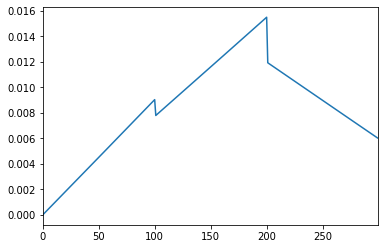

In [950]:
%matplotlib inline
import matplotlib
pandas.Series(ratesA).plot()

## Random Simulation

In [951]:
chain = blockchain(1,1)
oracle.setPrice(Decimal('2'))
tokenA = Token("TokenA")
tokenB = Token("TokenB")
oracle = Oracle(tokenA, tokenB)
oracle.setPrice(Decimal('1'))
interface = Interface(chain, tokenA, tokenB, oracle)

interface.A.mint("HODL", Decimal(100000))
interface.B.mint("HODL", Decimal(100000))
interface.eth.mint("BU", Decimal(1000))
interface.pyA.addCollateral("ETH", "BU", Decimal(100) )
interface.pyB.addCollateral("ETH", "BU", Decimal(100) )

price = interface.ethAOracle.getPriceInToken(interface.A)
borrow = (Decimal(25) * price) / (interface.pyA.collateralizationRatio )
interface.pyA.borrow("ETH", "BU", borrow)
interface.qxA.mint("HODL", Decimal(1500 * 0.15))

priceB = interface.ethBOracle.getPriceInToken(interface.B)
borrowB = (Decimal(50) * priceB) / (interface.pyB.collateralizationRatio )
interface.pyB.borrow("ETH", "BU", borrowB)

In [952]:
pyratesA = []
debtratesA = []
tSupply = []
ulying = []

In [953]:
for i in range(1000):
    print("Imbalance {}".format(interface.qxA.measureRatio()))
    amount = Decimal(round(numpy.random.lognormal(4, 1),0))
    if random.choice(["mint","redeem"]) == "mint":
        print("Mint {}".format(amount))
        interface.qxA.mint("HODL", amount)
    else:
        if interface.qxA.underlying > amount:
            print("Redeem {}".format(amount))
            interface.qxA.redeem("HODL", amount)
    
    pyratesA.append(float(interface.pyA.yearlyRate()))
    #ratesB.append(float(interface.pyB.yearlyRate()))
    debtratesA.append(float(interface.pyA.yearlyDebtRate()))
    tSupply.append(float(interface.pyA.totalSupply))
    ulying.append(float(interface.qxA.underlying))
    interface.eachBlock()

Imbalance 0.1326973113616652211621856028
Mint 282
Imbalance 0.2563728843808560635355007586
Mint 72
Imbalance 0.2824957667250236776396980743
Redeem 7
Imbalance 0.2800368621126598318166109896
Redeem 29
Imbalance 0.2696678449358768367853699863
Redeem 82
Imbalance 0.2386637025306818527880135214
Redeem 64
Imbalance 0.2125736243661217676147280230
Redeem 45
Imbalance 0.1931319390579325592887274026
Mint 49
Imbalance 0.2142565295122690818396590196
Mint 104
Imbalance 0.2556200684558776328878083099
Mint 89
Imbalance 0.2877087013116225933421518560
Redeem 22
Imbalance 0.2800368620648441684368525894
Redeem 39
Imbalance 0.2660227238808986004265709759
Mint 28
Imbalance 0.2761386338624624705103742956
Mint 35
Imbalance 0.2883980415935363815025117949
Mint 90
Imbalance 0.3180950301942720122890235615
Mint 67
Imbalance 0.3386418347871083790191639212
Redeem 46
Imbalance 0.3246711147497235655973120415
Mint 79
Imbalance 0.3483134350840867127180729856
Mint 15
Imbalance 0.3526167231181839980671729018
Mint 331
Im

Redeem 25
Imbalance 0.7505611477824780685744107938
Mint 75
Imbalance 0.7536944926017656016842905306
Mint 49
Imbalance 0.7556994417747481693182877621
Mint 31
Imbalance 0.7569511079154910287586571308
Mint 120
Imbalance 0.7616777016562491526842816476
Mint 28
Imbalance 0.7627542409171355346585993571
Mint 51
Imbalance 0.7646902936453503648531431457
Mint 69
Imbalance 0.7672599132073018473716588593
Mint 86
Imbalance 0.7703851172849712464835460545
Redeem 1931
Imbalance 0.6712731191356876883176081498
Redeem 32
Imbalance 0.6689047639513161474023036077
Redeem 66
Imbalance 0.6639106281012837832453241636
Redeem 35
Imbalance 0.6612005976918045838050866342
Mint 31
Imbalance 0.6636031066241443892506901141
Redeem 251
Imbalance 0.6431119531720211412364052043
Redeem 11
Imbalance 0.6421566828093311383879068657
Redeem 39
Imbalance 0.6387282134689660712354119874
Redeem 15
Imbalance 0.6373920137502339993972777330
Redeem 11
Imbalance 0.6364058349542922180152830133
Mint 138
Imbalance 0.648402231330466152247249

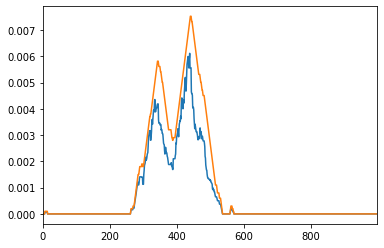

In [954]:
pandas.Series(pyratesA).plot()
pandas.Series(debtratesA).plot()

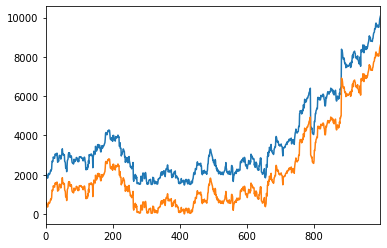

In [955]:
pandas.Series(tSupply).plot()
pandas.Series(ulying).plot()

## Agents

In [1150]:
class Agent:
    def __init__(self, _interface):
        self.interface = _interface
        self.address = numpy.random.randint(1,1000)
        
    def setup(self):
        pass
    
    def performActions(self):
        pass
    
    def shutdown(self):
        pass
    

class YieldAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = "0xYA_HodlPY" + str(self.address)
        
    def setup(self):   
        self.initialA = min(Decimal(round(numpy.random.lognormal(6, 1))), Decimal(1000))
        self.initialB = min(Decimal(round(numpy.random.lognormal(6, 1))), Decimal(1000))
        #self.initialA =  Decimal(1000000000)
        #self.initialB =  Decimal(1000000000)
        self.interface.A.mint(self.address, Decimal(self.initialA))
        self.interface.B.mint(self.address, Decimal(self.initialB))
        self.initial_exchange_rate = self.interface.oracle.currentPrice()
        self.lowerRate = Decimal(numpy.random.uniform(0,3) / 100)
        self.upperRate = self.lowerRate + Decimal(numpy.random.uniform(0,3) / 100)
    
    def performActions(self):
        if self.interface.pyA.yearlyRate() > self.upperRate:
            self.HODL()
        elif self.interface.pyA.yearlyRate() < self.lowerRate:
            self.unHODL()
            
    def HODL(self):
        if self.interface.A.balanceOf(self.address) > 0:
            aBalance = self.interface.A.balanceOf(self.address)
            self.interface.qxA.mint(self.address, aBalance)
            print("HODLing {} tokens at rate {}".format(aBalance, round(self.upperRate, 4)))
            
    def unHODL(self):
        amount = min(self.interface.pyA.balanceOfUnderlying(self.address), self.interface.qxA.underlying)
        if amount > 0:
            self.interface.qxA.redeem(self.address, amount*Decimal('0.99'))
            print("unHODLing {} tokens".format(amount*Decimal('0.99'), round(self.lowerRate, 4)))
            
            
# Borrow agents lever up on ETH collateral by selling pyTokens
class BorrowAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = "0xBA_longETH" + str(self.address)
        
    def setup(self):
        self.initialETH = min(Decimal(round(numpy.random.lognormal(3, 1))), Decimal(100))
        self.interface.eth.mint(self.address, Decimal(self.initialETH ))
        ethReserve = self.initialETH * Decimal('0.1')
        self.each = (self.initialETH - ethReserve)/2
        self.interface.pyA.addCollateral("ETH", self.address, self.each )
        self.interface.pyB.addCollateral("ETH", self.address, self.each )
        price = self.interface.ethAOracle.getPriceInToken(self.interface.A)
        self.desiredBorrow = Decimal('0.5')*self.interface.pyA.maximumBorrow("ETH", self.address)
        self.interface.A.mint(self.address, borrow*1000)
        self.lowerRate = Decimal(numpy.random.uniform(0,4) / 100)
        self.upperRate = Decimal(numpy.random.uniform(4,20) / 100)
    
    def performActions(self):
        if self.interface.pyA.yearlyDebtRate() > self.upperRate:
            self.unBorrow()
        elif self.interface.pyA.yearlyDebtRate() < self.lowerRate:
            self.borrow()
        uAmount = min(self.interface.pyA.balanceOfUnderlying(self.address), self.interface.qxA.underlying)
        if uAmount > Decimal('0.1'):
            self.interface.qxA.redeem(self.address, uAmount*Decimal(.99))
            print("Withdrew {} tokens at {}".format(round(uAmount*Decimal(.99), 4), round(self.lowerRate, 4) ))
            
            
    def borrow(self):
        price = self.interface.ethAOracle.getPriceInToken(self.interface.A)
        #if we've already mostly borrowed what we desire, let's stop
        if self.interface.pyA.debtInUnderlying("ETH", self.address) > Decimal('.99') * self.desiredBorrow:
            return
        #initiate borrow
        borrowRatio = Decimal('0.5')
        amount = self.interface.pyA.maximumBorrow("ETH", self.address) - self.interface.pyA.debtInUnderlying("ETH", self.address)
        borrow = (amount * borrowRatio) / (self.interface.pyA.collateralizationRatio )
        if borrow > Decimal('0.1'):
            self.interface.pyA.borrow("ETH", self.address, borrow)
            print("Borrowed {} tokens at {}".format(round(borrow, 4), round(self.lowerRate, 4) ))

    
    def unBorrow(self):
        amount = Decimal('0.95') * self.interface.pyA.debtInUnderlying("ETH", self.address)
        #funds = self.interface.A.balanceOf(self.address)
        #toUnBorrow = min(debt, funds)
        if amount > Decimal('0.1'):
            try:
                self.interface.qxA.mint(self.address, amount*Decimal(1.01))
                self.interface.pyA.repay("ETH", self.address, amount)
                print("unBorrowed {} tokens at {}".format(round(amount, 4), round(self.upperRate, 4) ))
            except Exception as e: 
                print("failed to unborrow. amount:{} underlying balance: {} pyTokens: {} ".format(amount, self.interface.A.balanceOf(self.address), self.interface.pyA.balanceOfUnderlying(self.address)))
                raise e
    


In [1151]:
import numpy

chain = blockchain(1,1)
oracle.setPrice(Decimal('2'))
tokenA = Token("TokenA")
tokenB = Token("TokenB")
oracle = Oracle(tokenA, tokenB)
oracle.setPrice(Decimal('1'))
interface = Interface(chain, tokenA, tokenB, oracle)

pyAinterest = []
pyBinterest = []
qxA = []
qxB = []
pyratesA = []
debtratesA = []
tSupply = []
ulying = []
debtOutstanding = []


interface.A.mint("HODL", Decimal(100000))
interface.B.mint("HODL", Decimal(100000))
interface.eth.mint("BU", Decimal(1000))
interface.pyA.addCollateral("ETH", "BU", Decimal(100) )
interface.pyB.addCollateral("ETH", "BU", Decimal(100) )

price = interface.ethAOracle.getPriceInToken(interface.A)
#borrow = (Decimal(25) * price) / (interface.pyA.collateralizationRatio )
#borrow = Decimal(100)
#interface.pyA.borrow("ETH", "BU", borrow)
#interface.qxA.mint("HODL", Decimal(1500 * 0.15))

#Create users

#user1 = YieldAgent(interface)
#user2 = BorrowAgent(interface)
#users = [user1, user2]

users = []
for x in range(60):
    users.append(YieldAgent(interface))
    
for y in range(20):
    users.append(BorrowAgent(interface))

# Setup
for user in users:
    user.setup()

# Run
for block in range(600):
    # perform interest rate update at beginning of block
    interface.eachBlock()
    
    for user in users:
        user.performActions()
    
    pyAinterest.append(float(interface.pyA.yearlyRate()))
    qxA.append(float(interface.qxA.measureRatio()))
    debtOutstanding.append(float(interface.pyA.getTotalDebt()))
    pyratesA.append(float(interface.pyA.yearlyRate()))
    debtratesA.append(float(interface.pyA.yearlyDebtRate()))
    tSupply.append(float(interface.pyA.totalSupply))
    ulying.append(float(interface.qxA.underlying))
    
# Shutdown
for user in users:
    user.shutdown()

Borrowed 163.4948 tokens at 0.0267
Borrowed 54.4983 tokens at 0.0380
Borrowed 778.5467 tokens at 0.0292
Borrowed 23.3564 tokens at 0.0119
Borrowed 31.1419 tokens at 0.0008
Borrowed 249.1349 tokens at 0.0258
Borrowed 147.9239 tokens at 0.0023
Borrowed 38.9273 tokens at 0.0384
Borrowed 124.5675 tokens at 0.0046
Borrowed 124.5675 tokens at 0.0324
Borrowed 124.5675 tokens at 0.0071
Borrowed 62.2837 tokens at 0.0157
Borrowed 140.1384 tokens at 0.0016
Borrowed 62.2837 tokens at 0.0065
Borrowed 249.1349 tokens at 0.0155
Borrowed 303.6332 tokens at 0.0286
Borrowed 194.6367 tokens at 0.0001
Borrowed 124.5675 tokens at 0.0089
Borrowed 132.3529 tokens at 0.0093
Borrowed 210.2076 tokens at 0.0248
Borrowed 115.4081 tokens at 0.0267
Borrowed 38.4694 tokens at 0.0380
Borrowed 549.5624 tokens at 0.0292
Borrowed 16.4869 tokens at 0.0119
Borrowed 21.9825 tokens at 0.0008
Borrowed 175.8600 tokens at 0.0258
Borrowed 104.4169 tokens at 0.0023
Borrowed 27.4781 tokens at 0.0384
Borrowed 87.9300 tokens at 0.0

HODLing 314.8205822516076018125663088 tokens at rate 0.0085
unHODLing 314.8205857211312457657432355 tokens
HODLing 314.8205857211312457657432355 tokens at rate 0.0085
unHODLing 314.8205891906549279552839661 tokens
HODLing 314.8205891906549279552839661 tokens at rate 0.0085
unHODLing 314.8205926601786483811889220 tokens
HODLing 314.8205926601786483811889220 tokens at rate 0.0085
unHODLing 314.8205961297024070434585245 tokens
HODLing 314.8205961297024070434585245 tokens at rate 0.0085
unHODLing 314.8205995992262039420931952 tokens
HODLing 314.8205995992262039420931952 tokens at rate 0.0085
unHODLing 314.8206030687500390770933555 tokens
HODLing 314.8206030687500390770933555 tokens at rate 0.0085
unHODLing 314.8206065382739124484594268 tokens
HODLing 314.8206065382739124484594268 tokens at rate 0.0085
unHODLing 314.8206100077978240561918303 tokens
HODLing 314.8206100077978240561918303 tokens at rate 0.0085
unHODLing 314.8206134773217739002909876 tokens
HODLing 314.8206134773217739002909876

unHODLing 314.8215675978590526224316869 tokens
HODLing 314.8215675978590526224316869 tokens at rate 0.0085


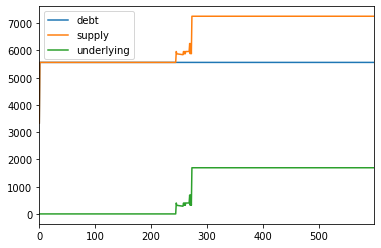

In [1152]:
pandas.Series(debtOutstanding, name="debt").plot(legend=True)
pandas.Series(tSupply, name="supply").plot(legend=True)
pandas.Series(ulying, name="underlying").plot(legend=True)

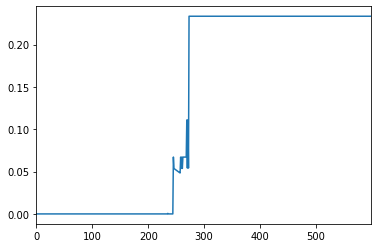

In [1153]:
pandas.Series(qxA).plot()


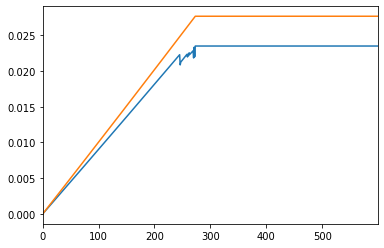

In [1154]:
pandas.Series(pyratesA).plot()
pandas.Series(debtratesA).plot()

In [1155]:
interface.A.balances

{'0xReferenceExchange': Decimal('1000000000'),
 'HODL': Decimal('100000'),
 '0xYA_HodlPY255': Decimal('245'),
 '0xYA_HodlPY746': Decimal('388'),
 '0xYA_HodlPY768': Decimal('97'),
 '0xYA_HodlPY417': Decimal('500'),
 '0xYA_HodlPY247': Decimal('1000'),
 '0xYA_HodlPY874': Decimal('1000'),
 '0xYA_HodlPY556': Decimal('194'),
 '0xYA_HodlPY826': Decimal('1000'),
 '0xYA_HodlPY368': Decimal('778'),
 '0xYA_HodlPY877': Decimal('0'),
 '0xYA_HodlPY816': Decimal('0E-25'),
 '0xYA_HodlPY203': Decimal('0'),
 '0xYA_HodlPY948': Decimal('0'),
 '0xYA_HodlPY87': Decimal('1000'),
 '0xYA_HodlPY357': Decimal('328'),
 '0xYA_HodlPY600': Decimal('0'),
 '0xYA_HodlPY336': Decimal('195'),
 '0xYA_HodlPY831': Decimal('457'),
 '0xYA_HodlPY961': Decimal('222'),
 '0xYA_HodlPY103': Decimal('242'),
 '0xYA_HodlPY625': Decimal('506'),
 '0xYA_HodlPY953': Decimal('475'),
 '0xYA_HodlPY914': Decimal('1000'),
 '0xYA_HodlPY231': Decimal('0'),
 '0xYA_HodlPY951': Decimal('254'),
 '0xYA_HodlPY360': Decimal('60'),
 '0xYA_HodlPY769': De

In [1156]:
interface.pyA.balances

{'0xBA_longETH794': Decimal('0.027890291063802138242343980'),
 '0xBA_longETH210': Decimal('0.0092967636879340460807813264'),
 '0xBA_longETH226': Decimal('0.054876775409473513310042236'),
 '0xBA_longETH76': Decimal('0.0032049859506473190354152094'),
 '0xBA_longETH569': Decimal('0.0053124363931051691890179009'),
 '0xBA_longETH28': Decimal('0.0056290150400140830704477540'),
 '0xBA_longETH537': Decimal('0.024865368106201280615942461'),
 '0xBA_longETH298': Decimal('0.0066405454913814614862723759'),
 '0xBA_longETH685': Decimal('0.013218340565676806406651305'),
 '0xBA_longETH344': Decimal('0.019538888271602062847024362'),
 '0xBA_longETH169': Decimal('0.015861905726963071000447930'),
 '0xBA_longETH238': Decimal('0.010571157442080837390428999'),
 '0xBA_longETH47': Decimal('0.023905963768973261350580553'),
 '0xBA_longETH595': Decimal('0.010624872786210338378035802'),
 '0xBA_longETH862': Decimal('0.042499491144841353512143207'),
 '0xBA_longETH552': Decimal('0.031324749895153035480076162'),
 '0xBA

In [1081]:
numpy.random.lognormal(5, 1)

84.13137852413993